In [1]:
import numpy as np
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2

# optimizing and interpolation
from scipy import optimize
from scipy import interpolate
from copy import copy

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d 
import seaborn as sns

plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = sns.color_palette()

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.0
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["legend.edgecolor"] = "black"

# Consumption saving with borrowing

We are now considering the consumption-savings model with an extension: households may **borrow** money in the first period. Additionally, there are **2 kinds** of households: the first type will likely see a **low level** of period 2 income, whereas the second type will likely see a **high** second period income. 

A household lives for 2 periods and makes decisions on consumption and saving in each period.  

**Second period:**   
Solving the consumer problem in the second period is similar to the baseline case we have seen before.

The household gets utility from **consuming** and **leaving a bequest** (warm glow),

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

where
* $m_t$ is cash-on-hand 
* $c_t$ is consumption
* $a_t$ is end-of-period assets 
* $\rho > 1$ is the risk aversion coefficient
* $\nu > 0 $ is the strength of the bequest motive
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* $a_2\geq0$ ensures the household *cannot* die in debt

**First period:**   
The household gets utility from immediate consumption.  Household takes into account that next period income is stochastic.

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
a_1 & = m_1 - c_1 \\
m_2 & = (1+r)a_1 + y_2 \\
y_{2} & = \begin{cases}
1 - \Delta & \text{with prob. } P_{low}\\
1 + \Delta & \text{with prob. } P_{high} 
\end{cases}\\
a_1 & > -\frac{1-\Delta}{1+r} 
\end{aligned}
$$

where
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y_2$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk 
* $r$ is the interest rate
* $\frac{1-\Delta}{1+r} > c_1 - m_1$ ensures the household cannot borrow *more* than it will be able to repay in next period when $y_2$ is received.

The **2 types** of households are defined by their different $(P_{low},P_{high})$:
* Type 1: 
    * $P_{low} = 0.9$ 
    * $P_{high} = 0.1$
* Type 2:
    * $P_{low} = 0.1$ 
    * $P_{high} = 0.9$

In [2]:
# Parameters
rho = 3
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.95
Delta = 0.5

**Question 1** Solve the model for each type of household. Plot the value functions $v_1(m_1)$ and $v_2(m_2)$ in one graph for each household type. Comment on the differences.

In [3]:
# Set parameters
par = SimpleNamespace()
par.rho = rho
par.kappa = kappa
par.nu = nu
par.r = r
par.beta = beta
par.Delta = Delta
par.max_debt = (1-par.Delta)/(1+par.r)

# Type 1
par1 = copy(par)
par1.prb = {'low': 0.9, 'high': 0.1}

# Type 2
par2 = copy(par)
par2.prb = {'low': 0.1, 'high': 0.9}

Agents can have two different values of the probability parameters, we have to include that in a "smart" way.  
I do it slighty different that Jeppe to show that there are many solutions.

In [4]:
print("Column names are type")
dic = {"type 1": [0.9, 0.1], "type 2": [0.1, 0.9]}
pd.DataFrame(dic)

Column names are type


,type 1,type 2
0,0.9,0.1
1,0.1,0.9


In [5]:
def utility(par, c):
    
    return c**(1-par.rho)/(1-par.rho)

def bequest(par, m, c):
    
    return par.nu*(m-c+par.kappa)**(1-par.rho)/(1-par.rho)

def v2(par, c2, m2):
    
    return utility(par, c2) + bequest(par, m2, c2)

def v1(par, c1, m1, v2_interp):
    
    # a. v2 if low income realization
    m2_low = (1+par.r)*(m1-c1) + 1-par.Delta
    v2_low = v2_interp([m2_low])[0]

    # b. v2 if high income realization
    m2_high = (1+par.r)*(m1-c1) + 1+par.Delta
    v2_high = v2_interp([m2_high])[0]

    # c. Expected v2 value
    expected_v2 = par.prb['low']*v2_low + par.prb['high']*v2_high

    # d. Total value
    return utility(par, c1) + par.beta*expected_v2

In [6]:
def solve_period_2(par):

    # a. Initialize grids
    m2s = np.linspace(1e-4,5,500)
    v2s = np.empty(500)
    c2s = np.empty(500)

    # b. Solve consumption problem for each m2 in grid
    for i,m2 in enumerate(m2s):

        # i. Objective function
        obj = lambda x: -v2(par, x[0], m2)

        # ii. Initial guess (consume half of m2)
        x0 = m2/2

        # iii. Optimize the objective of allocating between consumption and bequests
        result = optimize.minimize(obj, [x0], method='L-BFGS-B', bounds=((1e-8, m2),))

        # iv. Save solution
        v2s[i] = -result.fun
        c2s[i] = result.x

    return m2s, v2s, c2s


def solve_period_1(par, v2_interp):
    
    # a. Initialize grids
    m1s = np.linspace(1e-8, 5, 100)
    v1s = np.empty(100)
    c1s = np.empty(100)

    # b. Solve for each m1 in the grid
    for i, m1 in enumerate(m1s):

        # i. Objective function
        def obj(x): return -v1(par, x[0], m1, v2_interp)

        # ii. Initial guess (consume half of m1)
        x0 = m1/2

        # iii. Optimize the objective given debt constraint
        result = optimize.minimize(obj, [x0], 
                                   method='L-BFGS-B', bounds=((1e-12, m1 + par.max_debt),))

        # iv. Save solution
        v1s[i] = -result.fun
        c1s[i] = result.x[0]

    return m1s, v1s, c1s

def solve(par):
    
    def solution_to_dict(sol):
        names = ['m','v','c']
        return dict((n, i) for n,i in zip(names, sol))
    
    # a. solve period 2
    sol2 = solve_period_2(par)    
    sol2 = solution_to_dict(sol2)

    # b. construct interpolator
    v2_interp = interpolate.RegularGridInterpolator([sol2['m']], sol2['v'],
                                                    bounds_error=False, fill_value=None)

    # c. solve period 1
    sol1 = solve_period_1(par, v2_interp)
    sol1 = solution_to_dict(sol1)

    return {'t1': sol1, 't2': sol2}

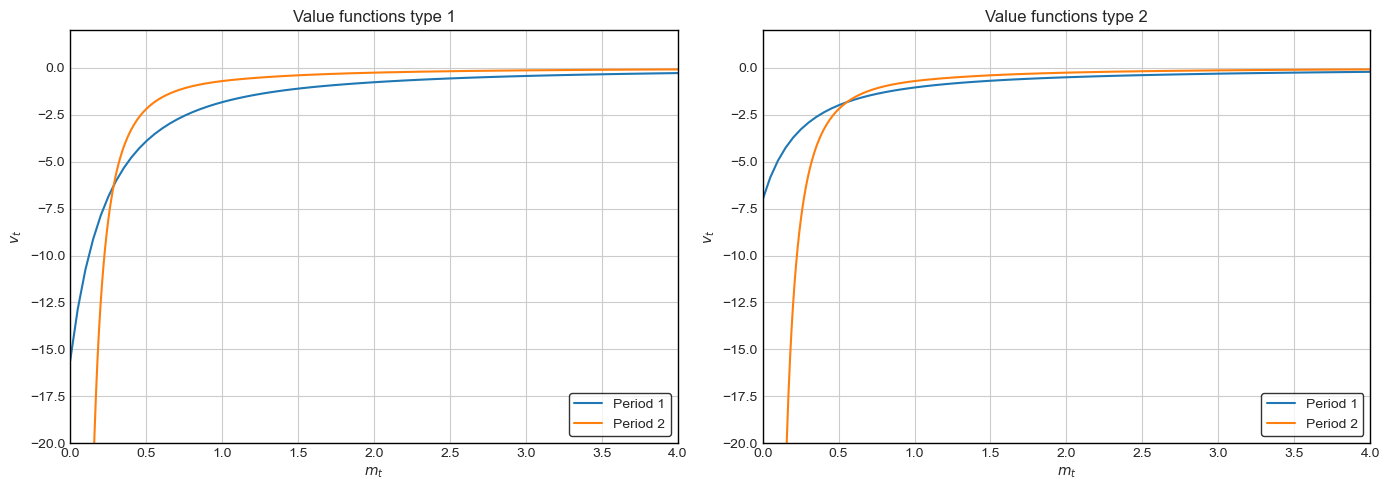

In [7]:
# a. Solve for both types of households
types = {1: par1, 2: par2}
solutions = {}

for i,p in types.items():
    solutions[i] = solve(p)

# b. Plot value functions for both types
fig = plt.figure(figsize=(14,5))
for i,sol in solutions.items():    
    ax = fig.add_subplot(1,2,i)
    ax.plot(sol['t1']['m'], sol['t1']['v'], label=f'Period 1')
    ax.plot(sol['t2']['m'], sol['t2']['v'], label=f'Period 2')
    ax.legend(loc='lower right',facecolor='white',frameon=True)
    ax.set_xlabel('$m_t$')
    ax.set_ylabel('$v_t$')
    ax.set_title(f'Value functions type {i}');
    ax.set_xlim([0,4])
    ax.set_ylim([-20, 2]);

## Why interpolate?

In [8]:
print("period 2")
dic = {"m period 2": sol['t2']['m'], "c period 2": sol['t2']['c']}
pd.DataFrame(dic).round(3) # I only round to show you

period 2


,m period 2,c period 2
0,0.00,0.000
1,0.01,0.010
2,0.02,0.020
3,0.03,0.030
4,0.04,0.040
...,...,...
495,4.96,3.729
496,4.97,3.736
497,4.98,3.743
498,4.99,3.750


To get points that are not on the grid.. for example, m = 0.3

In [9]:
print(f"m = {sol['t2']['m'][199]}, c = {sol['t2']['c'][199]}") # m is rougly below 2.0 at index 199
print(f"m = {sol['t2']['m'][200]}, c = {sol['t2']['c'][200]}")

m = 1.9940480961923848, c = 1.70339853225173
m = 2.0040679358717437, c = 1.7102428323258327


In [10]:
c_interp = interpolate.RegularGridInterpolator([sol['t2']['m']], sol['t2']['c'], bounds_error=False, fill_value=None)
c_interp([2.0]) # in the middle

array([1.70746413])

In [11]:
a = np.linspace(1.8, 2.2, 100)
b = c_interp(a)
dic = {"m": a , "c": b}
pd.DataFrame(dic).round(3) # see how we get more points!

,m,c
0,1.800,1.571
1,1.804,1.574
2,1.808,1.576
3,1.812,1.579
4,1.816,1.582
...,...,...
95,2.184,1.833
96,2.188,1.836
97,2.192,1.839
98,2.196,1.841


**Question 2** From the model solution, obtain the optimal consumption functions $c_1^*(m_1)$ and $c_2^*(m_2)$. Plot these in one graph for each type of household. Comment on the observed differences between household types. 

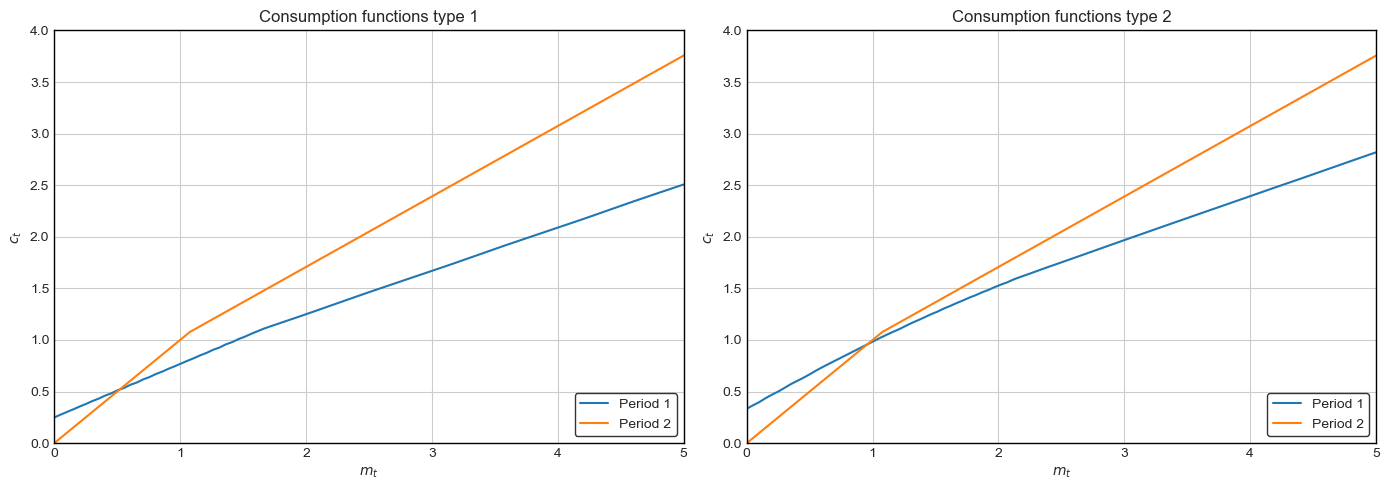

In [12]:
# Plot consumption functions for both types
fig = plt.figure(figsize=(14,5))
for i,sol in solutions.items():    
    ax = fig.add_subplot(1,2,i)
    ax.plot(sol['t1']['m'], sol['t1']['c'], label=f'Period 1')
    ax.plot(sol['t2']['m'], sol['t2']['c'], label=f'Period 2')
    ax.legend(loc='lower right',facecolor='white',frameon=True)
    ax.set_xlabel('$m_t$')
    ax.set_ylabel('$c_t$')
    ax.set_title(f'Consumption functions type {i}');
    ax.set_xlim([0,5])
    ax.set_ylim([0, 4]);

**Question 3** Simulate `simN` households of each type based on the distribution of $m_1$ below. You can use the same distribution for both household types. What is the fraction of households who *borrow* in period 1, $c_1 > m_1$, in each group?

In [13]:
np.random.seed(2021)
simN = 100000
sim_m1 = np.fmax(np.random.normal(1, 1, size = simN), 0) # No one gets negative m in first period

In [14]:
def simulate(par):
    # a. Solve the model for both periods
    sol = solve(par)

    # b. Construct interpolaters between cash and consumption choices
    c1_interp = interpolate.RegularGridInterpolator([sol['t1']['m']], sol['t1']['c'],
                                                    bounds_error=False, fill_value=None)

    c2_interp = interpolate.RegularGridInterpolator([sol['t2']['m']], sol['t2']['c'],
                                                    bounds_error=False, fill_value=None)

    # c. Simulate period 1 based on array of m and solution
    sim_c1 = c1_interp(par.sim_m1)
    sim_a1 = par.sim_m1 - sim_c1

    # d. Transition to period 2 cash-on-hand based on random draws of income and period 1 choices
    y2_low = 1-par.Delta
    y2_high = 1+par.Delta
    y2 = np.random.choice([y2_low, y2_high], 
                          p=[par.prb['low'], par.prb['high']], 
                          size=(sim_c1.shape))

    sim_m2 = (1+par.r)*sim_a1 + y2

    # e. sim period 2 consumption choice based on model solution and sim_m2
    sim_c2 = c2_interp(sim_m2)

    return {'c1': sim_c1, 'c2': sim_c2, 'sim_m2': sim_m2}

In [15]:
# a. Use the same distribution of cash-on-hand endowment for both types and simulate choices
for i,par in types.items():
    par.sim_m1 = copy(sim_m1)
    par.sim_c = simulate(par)    

# b. Calculate the share of borrowers in period 1
for i,par in types.items():
    borrowers = np.sum(par.sim_c['c1'] > par.sim_m1)/simN
    print(f'Share of borrowers in type {i}: {borrowers: .3f}')

Share of borrowers in type 1:  0.316
Share of borrowers in type 2:  0.484
